Здесь, в этом наборе данных, у нас есть задача контролируемого машинного обучения для прогнозирования сердечной недостаточности (Сердечно-сосудистых заболеваний - ССЗ)

# Импорт всех необходимых библиотек

In [54]:
!pip install catboost


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [55]:
import os
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import joblib

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
from sklearn import preprocessing
import matplotlib
matplotlib.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import pickle
from sklearn import model_selection
from catboost import CatBoostClassifier

In [56]:
#from google.colab import drive
#drive.mount('/content/drive')
path_in_drive = r"D:\Python_proj\test2\innopolis\ITOG\first/"

# Контекст

Сердечно-сосудистые заболевания (ССЗ) являются причиной смерти номер 1 во всем мире, ежегодно унося, по оценкам, 17,9 миллиона жизней, что составляет 31% всех смертей во всем мире. Четыре из 5 смертей от сердечно-сосудистых заболеваний происходят в результате сердечных приступов и инсультов, и треть этих смертей происходит преждевременно у людей в возрасте до 70 лет. Сердечная недостаточность является распространенным заболеванием, вызванным ССЗ, и этот набор данных содержит 11 признаков, которые можно использовать для прогнозирования возможного заболевания сердца.
Люди с сердечно-сосудистыми заболеваниями или с высоким сердечно-сосудистым риском (из-за наличия одного или нескольких факторов риска, таких как гипертония, диабет, гиперлипидемия или уже установленное заболевание) нуждаются в раннем выявлении и лечении, в чем модель машинного обучения может оказать большую помощь

In [57]:
df=pd.read_csv(str(path_in_drive+"heart.csv"))
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Функция describe() в pandas очень удобна для получения различной сводной статистики.Эта функция возвращает количество, среднее значение, стандартное отклонение, минимальное и максимальное значения и квантили данных.

In [58]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

Поскольку мы видим, что строковые данные в dataframe находятся в форме object, нам нужно преобразовать их обратно в string, чтобы поработать с ними

In [59]:
string_col = df.select_dtypes(include="object").columns
df[string_col]=df[string_col].astype("string")

In [60]:
df.dtypes

Age                 int64
Sex                string
ChestPainType      string
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         string
MaxHR               int64
ExerciseAngina     string
Oldpeak           float64
ST_Slope           string
HeartDisease        int64
dtype: object

Итак, как мы можем видеть здесь, данные объекта были преобразованы в строку

## Получение категориальных столбцов

In [61]:
string_col=df.select_dtypes("string").columns.to_list()

In [62]:
num_col=df.columns.to_list()
#print(num_col)
for col in string_col:
    num_col.remove(col)
num_col.remove("HeartDisease")

In [63]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


# Атрибуты:
- Age: возраст пациента [годы]
- Sex: пол пациента [M: Мужчина, F: Женщина]
- ChestPainType: тип боли в груди [TA: Типичная стенокардия, ATA: Атипичная стенокардия, NAP: Неангинальная боль, ASY: Бессимптомная]
- RestingBP: артериальное давление в состоянии покоя [мм рт.ст.]
- Cholesterol: уровень холестерина в сыворотке крови [мм/дл]
- FastingBS: уровень сахара в крови натощак [1: если уровень сахара в крови натощак > 120 мг/дл, 0: в противном случае]
- RestingECG [Норма: Нормальный, ST: наличие аномалии зубца ST-T (инверсии зубца T и/или подъем или понижение ST > 0,05 мВ), ГЛЖ: наличие вероятной или определенной гипертрофии левого желудочка по критериям Эстеса]
- MaxHR: достигнута максимальная частота сердечных сокращений [числовое значение от 60 до 202]
- СExerciseAngina: стенокардия, вызванная физической нагрузкой [Y: Да, N: Нет]
- Oldpeak: oldpeak = ST [Числовое значение, измеряемое при измерении давления]
- ST_Slope: наклон сегмента ST пикового упражнения [Up: наклонный, Flat: плоский, Down: наклонный]
- HeartDisease: выходной класс [1: сердечное заболевание, 0: Нормальное]

# Предварительный анализ данных

- Понимание данного набора данных и помощь в очистке данного набора данных.
- Представление об особенностях и взаимосвязях между ними.
- Предоставление рекомендаций по существенным переменным и оставление / удаление несущественных переменных.
- Обработка пропущенных значений или человеческой ошибки.
- Выявление выбросов.
- Процесс заключается в максимальном анализе набора данных.


## Корреляционная матрица
### Необходимо удалить коррелированные переменные, чтобы улучшить вашу модель.Можно найти корреляции с помощью функции pandas “.corr()” и визуализировать корреляционную матрицу с помощью plotly express.
- Более светлые оттенки представляют положительную корреляцию
- Более темные оттенки представляют отрицательную корреляцию

In [64]:
px.imshow(df.corr(),title="Корреляционная матрица для прогнозировани СЗЗ")

Здесь мы видим, что сердечные заболевания имеют высокую отрицательную корреляцию с "MaxHR" и несколько отрицательную корреляцию с "холестерином".
Положительная корреляция с "Oldpeak", "FastingBS" и "RestingBP".

In [65]:
# Показано распределение ССЗ заболеваний по отношению к мужчинам и женщинам
fig=px.histogram(df,
                 x="HeartDisease",
                 color="Sex",
                 hover_data=df.columns,
                 title="Распределение СЗЗ",
                 barmode="group")
fig.show()

In [66]:
fig=px.histogram(df,
                 x="ChestPainType",
                 color="Sex",
                 hover_data=df.columns,
                 title="Тип боли"
                )
fig.show()

In [67]:
fig=px.histogram(df,
                 x="Sex",
                 hover_data=df.columns,
                 title="Распределение полов в выборке")
fig.show()

In [68]:
fig=px.histogram(df,
                 x="RestingECG",
                 hover_data=df.columns,
                 title="Распределение показателя ЭКГ в покое")
fig.show()

Чтобы построить несколько попарных двумерных распределений в наборе данных, вы можете использовать функцию pairplot(). Это показывает взаимосвязь для (n, 2) комбинации переменных во фрейме данных в виде матрицы графиков, а диагональные графики являются одномерными графиками.

CPU times: total: 8.11 s
Wall time: 8.1 s


[]

<Figure size 1500x1000 with 0 Axes>

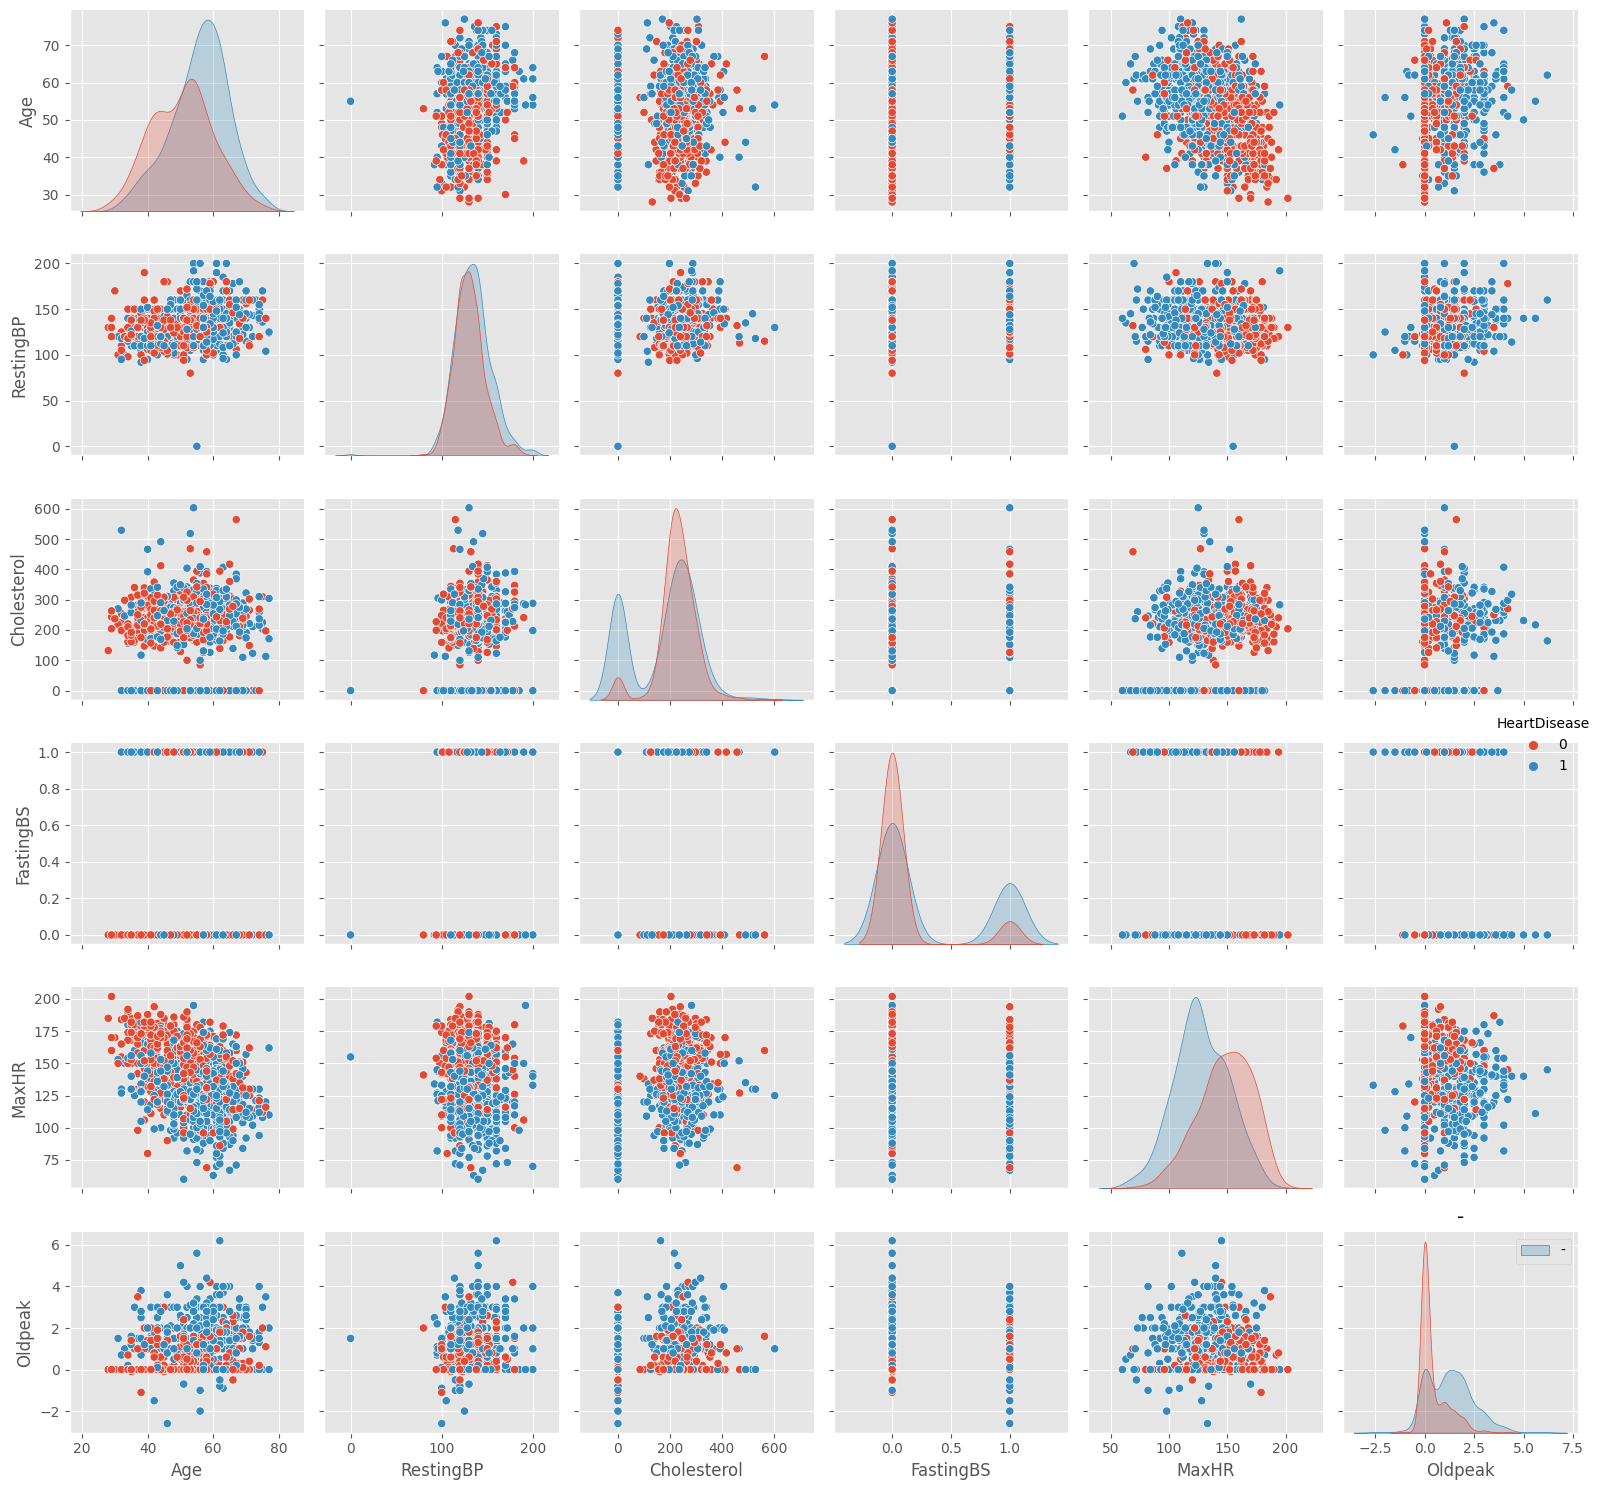

In [69]:
%%time
plt.figure(figsize=(15,10))
sns.pairplot(df,hue="HeartDisease")
plt.title("-")
plt.legend("-")
plt.tight_layout()
plt.plot()

### Теперь, чтобы проверить линейность переменных, рекомендуется построить график распределения и поискать асимметрию признаков. Kernel density estimate (kde) - довольно полезный инструмент для построения графика формы распределения.

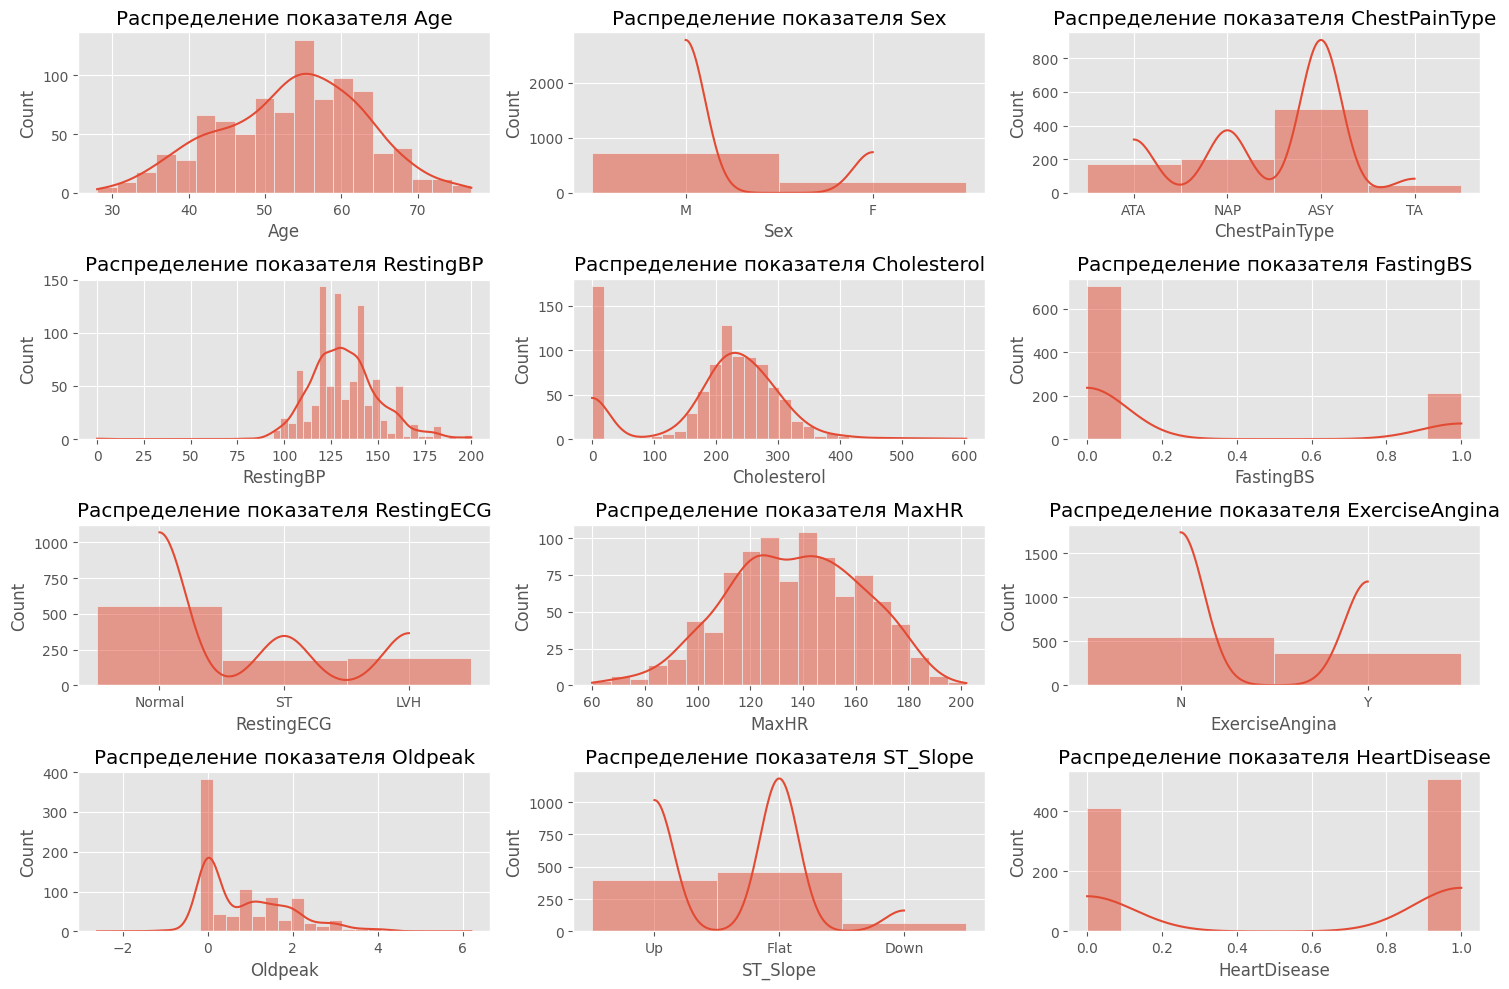

In [70]:
plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Распределение показателя {col}")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()



# Выбросы

Боксплот (или ящик с усами) показывает распределение количественных данных таким образом, чтобы облегчить сравнение между переменными.В рамке показаны квартили набора данных, в то время как усики расширяются, чтобы показать остальную часть распределения.Прямоугольный график (он же диаграмма прямоугольника и усов) - это стандартизированный способ отображения распределения данных на основе сводки из пяти чисел:
- Минимум
- Первый квартиль
- Медиана
- Третий квартиль
- Максимум.

На простейшем прямоугольном графике центральный прямоугольник охватывает первый квартиль до третьего квартиля (межквартильный диапазон или IQR).Сегмент внутри прямоугольника показывает медиану, а “усы” над и под прямоугольником показывают расположение минимума и максимума.

In [71]:
fig = px.box(df,y="Age",x="HeartDisease",title=f"Распределение возраста")
fig.show()

In [72]:
fig = px.box(df,y="RestingBP",x="HeartDisease",title=f"Распределение ЭКГ в покое",color="Sex")
fig.show()

In [73]:
fig = px.box(df,y="Cholesterol",x="HeartDisease",title=f"Распределение содержания холестерина")
fig.show()

In [74]:
fig = px.box(df,y="Oldpeak",x="HeartDisease",title=f"Распределение показтеля Oldpeak")
fig.show()

In [75]:
fig = px.box(df,y="MaxHR",x="HeartDisease",title=f"Распределение максимального пульса")
fig.show()

# Предварительная обработка данных
Предварительная обработка данных является неотъемлемым этапом машинного обучения, поскольку качество данных и полезная информация, которую можно извлечь из них, напрямую влияют на способность нашей модели к обучению; поэтому чрезвычайно важно, чтобы мы предварительно обрабатывали наши данные, прежде чем вводить их в нашу модель.

Этапы:
1. Обработка нулевых (отсуствующих) значений
2. Масштабирование показателей
3. Обработка категориальных переменных

# 1. Обработка нулевых значений :
В любом реальном наборе данных всегда есть несколько нулевых значений. На самом деле не имеет значения, является ли это регрессией, классификацией или какой-либо другой проблемой, ни одна модель не может справиться с этими значениями NULL или NaN самостоятельно.


In [76]:
# Checking for Type of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    string 
 2   ChestPainType   918 non-null    string 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    string 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    string 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    string 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), string(5)
memory usage: 86.2 KB


In [77]:
# Checking for NULLs in the data
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Таким образом, мы можем видеть, что наши данные не имеют никаких нулевых значений, но в случае, если у нас есть пропущенные значения, мы также можем удалить данные.

# 2. Масштабирование объектов

### Масштабирование объектов?
Некоторые алгоритмы машинного обучения чувствительны к масштабированию объектов, в то время как другие практически инвариантны к нему.

## 1. Алгоритмы, основанные на расстоянии :
Алгоритмы определения расстояния, такие как ** "KNN"**, ** "K-means"** и ** "SVM"**, в наибольшей степени зависят от диапазона функций. Это происходит потому, что за кулисами они используют расстояния между точками данных для определения их сходства.
Если два объекта имеют разные масштабы, есть вероятность, что объектам с большей величиной будет придан больший вес. Это повлияет на производительность алгоритма машинного обучения, и, очевидно, мы не хотим, чтобы наш алгоритм был ориентирован на какую-то одну функцию.
Поэтому мы масштабируем наши данные, прежде чем использовать алгоритм, основанный на расстоянии, чтобы все функции в равной…

## 2. Древовидные алгоритмы :
Древовидные алгоритмы, с другой стороны, довольно нечувствительны к масштабу объектов. Подумайте об этом, дерево решений - это всего лишь разделение узла на основе одного признака. Дерево решений разбивает узел на элементы, что увеличивает однородность узла. На это разделение объекта не влияют другие объекты.
Таким образом, остальные объекты практически не влияют на разделение. Это то, что делает их инвариантными к масштабу объектов!

### Что такое нормализация?

Нормализация - это метод масштабирования, при котором значения сдвигаются и перемасштабируются таким образом, чтобы в конечном итоге они находились в диапазоне от 0 до 1. Это также известно как минимальное-максимальное масштабирование.

Вот исходный код для нормализации :

<img src="https://i.stack.imgur.com/EuitP.png" width=40%>

Здесь Xmax и Xmin - это максимальное и минимальное значения объекта соответственно.

Когда значение X является минимальным значением в столбце, числитель будет равен 0, и, следовательно, X’ равно 0
С другой стороны, когда значение X является максимальным значением в столбце, числитель равен знаменателю и, таким образом, значение X’ равно 1
Если значение X находится между минимальным и максимальным значением, то значение X’ находится между 0 и 1

## Что такое стандартизация?

Стандартизация - это еще один метод масштабирования, при котором значения центрируются вокруг среднего значения с единичным стандартным отклонением. Это означает, что среднее значение атрибута становится равным нулю, а результирующее распределение имеет единичное стандартное отклонение

Вот формула для стандартизации:

<img src="https://clavelresearch.files.wordpress.com/2019/03/z-score-population.png" width=30%>

Главный вопрос – нормализовать или стандартизировать?

Нормализация против стандартизации - вечный вопрос среди новичков в машинном обучении. Позвольте мне подробнее остановиться на ответе в этом разделе.

- Нормализацию полезно использовать, когда вы знаете, что распределение ваших данных не соответствует гауссову распределению. Это может быть полезно в алгоритмах, которые не предполагают никакого распределения данных, таких как K-ближайшие соседи и нейронные сети.

- Стандартизация, с другой стороны, может быть полезна в случаях, когда данные соответствуют гауссову распределению. Однако это не обязательно должно быть правдой. Кроме того, в отличие от нормализации, стандартизация не имеет ограничивающего диапазона. Таким образом, даже если в ваших данных есть отклонения, стандартизация на них не повлияет.

Однако, в конце концов, выбор использования нормализации или стандартизации будет зависеть от вашей проблемы и используемого вами алгоритма машинного обучения. Не существует жесткого правила, которое указывало бы вам, когда следует нормализовать или стандартизировать ваши данные.

### Robust  масштабирование
При работе с выбросами мы можем использовать Robust масштабирование для масштабирования наших данных,
Он масштабирует функции, используя статистику, устойчивую к выбросам. Этот метод удаляет медиану и масштабирует данные в диапазоне от 1-го квартиля до 3-го квартиля. т.е. в диапазоне от 25-го квантиля до 75-го квантиля. Этот диапазон также называется межквартильным диапазоном.
Затем медиана и межквартильный диапазон сохраняются, чтобы их можно было использовать в будущих данных с использованием метода преобразования.Если в наборе данных присутствуют выбросы, то медиана и межквартильный диапазон дают лучшие результаты и превосходят среднее значение выборки и дисперсию.
RobustScaler использует межквартильный диапазон, чтобы быть устойчивым к выбросам

# 3. Обработка категориальных переменных

Категориальные переменные /объекты - это любой тип объектов, который можно разделить на два основных типа:
- Номинальные
- Порядковые

Номинальные переменные - это переменные, имеющие две или более категорий, которые не имеют никакого порядка, связанного с ними. Например, если гендер классифицируется на две группы, то есть на мужскую и женскую, его можно рассматривать как номинальную переменную.Порядковые переменные, с другой стороны, имеют “уровни” или категории, с которыми связан определенный порядок. Например, порядковая категориальная переменная может быть признаком с тремя различными уровнями: низким, средним и высоким. Важен порядок.
Это задача бинарной классификации:
цель здесь ** не искажена **, но мы используем наилучший показатель для этой задачи бинарной классификации, которым будет площадь под кривой ROC (AUC). Мы также можем использовать точность и отзыв, но AUC объединяет эти два показателя. Таким образом, мы будем использовать AUC для оценки модели, которую мы построим на основе этого набора данных.

Мы должны знать, что компьютеры не понимают текстовые данные, и, следовательно, нам нужно преобразовать эти категории в числа. Простым способом сделать это может быть использование :

- Label Encoding
```python
from sklearn.preprocessing import LabelEncoder
```
- One Hot Encoding
```python
pd.get_dummies()
```

**Для алгоритмов машинного обучения, не основанных на дереве, лучшим способом будет использовать однократное кодирование**
Преимущество однократного горячего кодирования в том, что результат является двоичным, а не порядковым, и что все находится в ортогональном векторном пространстве.
- Недостатком является то, что при высокой мощности пространство функций может действительно быстро увеличиться, и вы начнете бороться с проклятием размерности. В этих случаях я обычно использую однократное горячее кодирование с последующим PCA для уменьшения размерности. Я нахожу, что разумная комбинация one-hot плюс PCA редко может быть превзойдена другими схемами кодирования. PCA обнаруживает линейное перекрытие, поэтому, естественно, будет стремиться сгруппировать похожие объекты в один и тот же объект

**Для алгоритмов машинного обучения на основе дерева лучше всего использовать кодировку меток**

- LabelEncoder может превратить [dog,cat,собака, мышь, кот] в [1,2,1,3,2], но тогда введенная ординальность означает, что среднее значение dog и mouse равно cat. Тем не менее, существуют алгоритмы, такие как деревья решений и случайные леса, которые могут прекрасно работать с категориальными переменными, а LabelEncoder можно использовать для хранения значений, занимающих меньше места на диске.

In [78]:
df[string_col].head()
for col in string_col:
    print(f"Распределение показаний в колонке {col} : ")
    print(df[col].value_counts())

Распределение показаний в колонке Sex : 
M    725
F    193
Name: Sex, dtype: Int64
Распределение показаний в колонке ChestPainType : 
ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: Int64
Распределение показаний в колонке RestingECG : 
Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: Int64
Распределение показаний в колонке ExerciseAngina : 
N    547
Y    371
Name: ExerciseAngina, dtype: Int64
Распределение показаний в колонке ST_Slope : 
Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: Int64


In [79]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [80]:
# который будет использоваться с Tree Based алгоритмами
df_tree = df.copy()
dict_encoding = {}
encoder = LabelEncoder()
categorical_features = df_tree.columns.tolist()
for each in categorical_features:
    encoder.fit(df_tree[each])
    joblib.dump(encoder, path_in_drive+f'{each}_lblenc.pkl')
    encoder = joblib.load(path_in_drive+f'{each}_lblenc.pkl')
    df_tree[each] = encoder.transform(df[each])
df_tree.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,12,1,1,41,147,0,1,98,0,10,2,0
1,21,0,2,55,40,0,1,82,0,20,1,1
2,9,1,1,31,141,0,2,25,0,10,2,0
3,20,0,0,39,72,0,1,34,1,25,1,1
4,26,1,2,49,53,0,1,48,0,10,2,0


In [81]:
#df_tree.loc[485 ,:] , df.loc[485 ,:]

Мы можем использовать это непосредственно во многих древовидных моделях:
- Decision trees
- Random forest
- Extra Trees
- Или любая другая модель бустинга
    - XGBoost
    - GBM
    - LightGBM

Некоторый тип кодирования не может быть использован в линейных моделях, машинах опорных векторов или нейронных сетях, поскольку они ожидают, что данные будут нормализованы (или стандартизированы). Для этих типов моделей мы можем использовать иную кодировку как показано ниже (бинарная).
Как показано ниже:

In [82]:
## Создание one hot encoded столбцы для работы с алгоритмами, не основанными на дереве
df_nontree=pd.get_dummies(df,columns=string_col,drop_first=False)
df_nontree.head()
# Целевой столбец добавим в конце
target="HeartDisease"
y=df_nontree[target].values
df_nontree.drop("HeartDisease",axis=1,inplace=True)
df_nontree=pd.concat([df_nontree,df[target]],axis=1)
df_nontree.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,HeartDisease
0,40,140,289,0,172,0.0,0,1,0,1,...,0,0,1,0,1,0,0,0,1,0
1,49,160,180,0,156,1.0,1,0,0,0,...,0,0,1,0,1,0,0,1,0,1
2,37,130,283,0,98,0.0,0,1,0,1,...,0,0,0,1,1,0,0,0,1,0
3,48,138,214,0,108,1.5,1,0,1,0,...,0,0,1,0,0,1,0,1,0,1
4,54,150,195,0,122,0.0,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0


# Выбор правильной перекрестной проверки

Выбор правильной перекрестной проверки зависит от набора данных, с которым вы имеете дело, и выбор перекрестной проверки для одного набора данных может применяться, а может и не применяться к другим наборам данных. Однако существует несколько типов методов перекрестной проверки, которые являются наиболее популярными и широко используемыми.
К ним относятся:

- k-кратная перекрестная проверка
- стратифицированная k-кратная перекрестная проверка
Перекрестная проверка заключается в разделении обучающих данных на несколько частей. Мы обучаем модель на некоторых из этих деталей и тестируем на остальных


<br>

<img src="https://i.stack.imgur.com/8uEci.png" width=50%>
<br>

## 1. K-fold перекрестная проверка :

Как вы можете видеть, мы разделяем образцы и связанные с ними целевые показатели. Мы можем разделить данные на k различных наборов, которые исключают друг друга. Это известно как K-fold перекрестная проверка, мы можем разделить любые данные на k равных частей, используя KFold из scikit-learn. Каждой выборке присваивается значение от 0 до k-1 при использовании K-fold перекрестной проверки.

## 2. Stratified k-fold перекрестная проверка :

Если у вас есть искаженный набор данных для бинарной классификации с 90% положительных выборок и только 10% отрицательных выборок, вы не хотите использовать случайную K-fold перекрестную проверку. Использование простой K-fold перекрестной проверки для набора данных, подобного этому, может привести к сворачиванию всех отрицательных выборок. В этих случаях мы предпочитаем использовать стратифицированную K-fold перекрестную проверку. Стратифицированная перекрестная проверка в K-fold размере сохраняет соотношение меток в каждом сгибе постоянным. Таким образом, в каждом сгибе у вас будут одни и те же 90% положительных и 10% отрицательных образцов. Таким образом, какую бы метрику вы ни выбрали для оценки, она даст одинаковые результаты по всем складкам.


# Обучение нашей модели машинного обучения :

In [83]:
dict_res_al = pd.DataFrame()

# NON-TREE BASED ALGORITHMS

In [84]:
feature_col_nontree=df_nontree.columns.to_list()
feature_col_nontree.remove(target)

In [85]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,recall_score
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
acc_mod=recll_sc = []
recll_sc = []

kf=model_selection.StratifiedKFold(n_splits=5)
for fold , (trn_,val_) in enumerate(kf.split(X=df_nontree,y=y)):

    X_train=df_nontree.loc[trn_,feature_col_nontree]
    y_train=df_nontree.loc[trn_,target]

    X_valid=df_nontree.loc[val_,feature_col_nontree]
    y_valid=df_nontree.loc[val_,target]

    #print(pd.DataFrame(X_valid).head())
    ro_scaler=MinMaxScaler()
    X_train=ro_scaler.fit_transform(X_train)
    X_valid=ro_scaler.transform(X_valid)


    clf=LogisticRegression()
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_valid)
    print(f"The fold is : {fold} : ")
    print(classification_report(y_valid,y_pred))
    acc=roc_auc_score(y_valid,y_pred)
    acc_mod.append(acc)
    recll_sc.append(recall_score(y_valid,y_pred))
    print(f"The accuracy for Fold {fold+1} : {acc}")
    pass
dict_res_al.loc["LogisticRegression", ['accuracy','recall']] = [ np.array(acc_mod).mean(),np.array(recll_sc).mean() ]

The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        82
           1       0.93      0.83      0.88       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.87       184
weighted avg       0.88      0.88      0.88       184

The accuracy for Fold 1 : 0.8800813008130083
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        82
           1       0.91      0.80      0.85       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.86      0.85      0.85       184

The accuracy for Fold 2 : 0.8531802965088474
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.96      0.65      0.77        82
           1       0.78      0.98      0.87       102

    accuracy                       

In [86]:
from sklearn.naive_bayes import GaussianNB
acc_mod=recll_sc = []
kf=model_selection.StratifiedKFold(n_splits=5)
for fold , (trn_,val_) in enumerate(kf.split(X=df_nontree,y=y)):

    X_train=df_nontree.loc[trn_,feature_col_nontree]
    y_train=df_nontree.loc[trn_,target]

    X_valid=df_nontree.loc[val_,feature_col_nontree]
    y_valid=df_nontree.loc[val_,target]

    ro_scaler=MinMaxScaler()
    X_train=ro_scaler.fit_transform(X_train)
    X_valid=ro_scaler.transform(X_valid)

    clf=GaussianNB()
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_valid)
    print(f"The fold is : {fold} : ")
    print(classification_report(y_valid,y_pred))
    acc=roc_auc_score(y_valid,y_pred)
    acc_mod.append(acc)
    print(f"The accuracy for {fold+1} : {acc}")
    recll_sc.append(recall_score(y_valid,y_pred))
    pass

dict_res_al.loc["GaussianNB", ['accuracy','recall']] = [ np.array(acc_mod).mean(),np.array(recll_sc).mean() ]

The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        82
           1       0.93      0.79      0.86       102

    accuracy                           0.85       184
   macro avg       0.86      0.86      0.85       184
weighted avg       0.87      0.85      0.85       184

The accuracy for 1 : 0.8604734576757532
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        82
           1       0.93      0.85      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

The accuracy for 2 : 0.8837876614060258
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.96      0.63      0.76        82
           1       0.77      0.98      0.86       102

    accuracy                           0.83  

In [87]:
from sklearn.svm import SVC
acc_mod=recll_sc = []
kf=model_selection.StratifiedKFold(n_splits=5)
for fold , (trn_,val_) in enumerate(kf.split(X=df_nontree,y=y)):

    X_train=df_nontree.loc[trn_,feature_col_nontree]
    y_train=df_nontree.loc[trn_,target]

    X_valid=df_nontree.loc[val_,feature_col_nontree]
    y_valid=df_nontree.loc[val_,target]

    ro_scaler=MinMaxScaler()
    X_train=ro_scaler.fit_transform(X_train)
    X_valid=ro_scaler.transform(X_valid)

    clf=SVC(kernel="linear")
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_valid)
    print(f"The fold is : {fold} : ")
    print(classification_report(y_valid,y_pred))
    acc=roc_auc_score(y_valid,y_pred)
    acc_mod.append(acc)
    print(f"The accuracy for {fold+1} : {acc}")
    recll_sc.append(recall_score(y_valid,y_pred))
    pass

dict_res_al.loc["SVC(kernel=linear)", ['accuracy','recall']] = [ np.array(acc_mod).mean(),np.array(recll_sc).mean() ]

The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.81      0.91      0.86        82
           1       0.92      0.82      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.87      0.86       184
weighted avg       0.87      0.86      0.86       184

The accuracy for 1 : 0.8690817790530847
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.77      0.91      0.84        82
           1       0.92      0.78      0.85       102

    accuracy                           0.84       184
   macro avg       0.85      0.85      0.84       184
weighted avg       0.85      0.84      0.84       184

The accuracy for 2 : 0.8494739359158296
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.96      0.65      0.77        82
           1       0.78      0.98      0.87       102

    accuracy                           0.83  

In [88]:
from sklearn.svm import SVC
acc_mod=recll_sc = []
kf=model_selection.StratifiedKFold(n_splits=5)
for fold , (trn_,val_) in enumerate(kf.split(X=df_nontree,y=y)):

    X_train=df_nontree.loc[trn_,feature_col_nontree]
    y_train=df_nontree.loc[trn_,target]

    X_valid=df_nontree.loc[val_,feature_col_nontree]
    y_valid=df_nontree.loc[val_,target]

    ro_scaler=MinMaxScaler()
    X_train=ro_scaler.fit_transform(X_train)
    X_valid=ro_scaler.transform(X_valid)

    clf=SVC(kernel="sigmoid")
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_valid)
    print(f"The fold is : {fold} : ")
    print(classification_report(y_valid,y_pred))
    acc=roc_auc_score(y_valid,y_pred)
    acc_mod.append(acc)
    print(f"The accuracy for {fold+1} : {acc}")

    recll_sc.append(recall_score(y_valid,y_pred))
    pass

dict_res_al.loc["SVC(kernel=sigmoid)", ['accuracy','recall']] = [ np.array(acc_mod).mean(),np.array(recll_sc).mean() ]

The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.83      0.84      0.84        82
           1       0.87      0.86      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184

The accuracy for 1 : 0.852104256336681
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.71      0.77      0.74        82
           1       0.80      0.75      0.77       102

    accuracy                           0.76       184
   macro avg       0.75      0.76      0.75       184
weighted avg       0.76      0.76      0.76       184

The accuracy for 2 : 0.7566953610712578
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.85      0.73      0.78        82
           1       0.81      0.89      0.85       102

    accuracy                           0.82   

In [89]:
from sklearn.svm import SVC
acc_mod=recll_sc = []
kf=model_selection.StratifiedKFold(n_splits=5)
for fold , (trn_,val_) in enumerate(kf.split(X=df_nontree,y=y)):

    X_train=df_nontree.loc[trn_,feature_col_nontree]
    y_train=df_nontree.loc[trn_,target]

    X_valid=df_nontree.loc[val_,feature_col_nontree]
    y_valid=df_nontree.loc[val_,target]

    ro_scaler=MinMaxScaler()
    X_train=ro_scaler.fit_transform(X_train)
    X_valid=ro_scaler.transform(X_valid)

    clf=SVC(kernel="rbf")
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_valid)
    print(f"The fold is : {fold} : ")
    print(classification_report(y_valid,y_pred))
    acc=roc_auc_score(y_valid,y_pred)
    acc_mod.append(acc)
    print(f"The accuracy for {fold+1} : {acc}")

    recll_sc.append(recall_score(y_valid,y_pred))
    pass

dict_res_al.loc["SVC(kernel=rbf)", ['accuracy','recall']] = [ np.array(acc_mod).mean(),np.array(recll_sc).mean() ]

The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        82
           1       0.91      0.93      0.92       102

    accuracy                           0.91       184
   macro avg       0.91      0.91      0.91       184
weighted avg       0.91      0.91      0.91       184

The accuracy for 1 : 0.9108082257293162
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.77      0.90      0.83        82
           1       0.91      0.78      0.84       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.85      0.84      0.84       184

The accuracy for 2 : 0.8433763749402199
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.89      0.70      0.78        82
           1       0.79      0.93      0.86       102

    accuracy                           0.83  

In [90]:
from sklearn.svm import SVC
acc_mod=recll_sc = []
kf=model_selection.StratifiedKFold(n_splits=5)
for fold , (trn_,val_) in enumerate(kf.split(X=df_nontree,y=y)):

    X_train=df_nontree.loc[trn_,feature_col_nontree]
    y_train=df_nontree.loc[trn_,target]

    X_valid=df_nontree.loc[val_,feature_col_nontree]
    y_valid=df_nontree.loc[val_,target]

    ro_scaler=MinMaxScaler()
    X_train=ro_scaler.fit_transform(X_train)
    X_valid=ro_scaler.transform(X_valid)

    clf=SVC(kernel="poly")
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_valid)
    print(f"The fold is : {fold} : ")
    print(classification_report(y_valid,y_pred))
    acc=roc_auc_score(y_valid,y_pred)
    acc_mod.append(acc)
    print(f"The accuracy for {fold+1} : {acc}")

    recll_sc.append(recall_score(y_valid,y_pred))
    pass

dict_res_al.loc["SVC(kernel=poly)", ['accuracy','recall']] = [ np.array(acc_mod).mean(),np.array(recll_sc).mean() ]

The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        82
           1       0.92      0.89      0.91       102

    accuracy                           0.90       184
   macro avg       0.89      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

The accuracy for 1 : 0.897297943567671
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.77      0.90      0.83        82
           1       0.91      0.78      0.84       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.85      0.84      0.84       184

The accuracy for 2 : 0.8433763749402199
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.93      0.63      0.75        82
           1       0.77      0.96      0.85       102

    accuracy                           0.82   

In [91]:
from sklearn.neighbors import KNeighborsClassifier
acc_mod=recll_sc = []
kf=model_selection.StratifiedKFold(n_splits=5)
for fold , (trn_,val_) in enumerate(kf.split(X=df_nontree,y=y)):

    X_train=df_nontree.loc[trn_,feature_col_nontree]
    y_train=df_nontree.loc[trn_,target]

    X_valid=df_nontree.loc[val_,feature_col_nontree]
    y_valid=df_nontree.loc[val_,target]

    ro_scaler=MinMaxScaler()
    X_train=ro_scaler.fit_transform(X_train)
    X_valid=ro_scaler.transform(X_valid)

    clf=KNeighborsClassifier(n_neighbors=32)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_valid)
    print(f"The fold is : {fold} : ")
    print(classification_report(y_valid,y_pred))
    acc=roc_auc_score(y_valid,y_pred)
    acc_mod.append(acc)
    print(f"The accuracy for {fold+1} : {acc}")

    recll_sc.append(recall_score(y_valid,y_pred))
    pass

dict_res_al.loc["KNeighborsClassifier", ['accuracy','recall']] = [ np.array(acc_mod).mean(),np.array(recll_sc).mean() ]

The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        82
           1       0.93      0.93      0.93       102

    accuracy                           0.92       184
   macro avg       0.92      0.92      0.92       184
weighted avg       0.92      0.92      0.92       184

The accuracy for 1 : 0.9230033476805357
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.78      0.90      0.84        82
           1       0.91      0.79      0.85       102

    accuracy                           0.84       184
   macro avg       0.84      0.85      0.84       184
weighted avg       0.85      0.84      0.84       184

The accuracy for 2 : 0.8482783357245336
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.92      0.72      0.81        82
           1       0.81      0.95      0.87       102

    accuracy                           0.85  

In [92]:
feature_col_tree=df_tree.columns.to_list()
feature_col_tree.remove(target)

In [93]:
df_tree

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,12,1,1,41,147,0,1,98,0,10,2,0
1,21,0,2,55,40,0,1,82,0,20,1,1
2,9,1,1,31,141,0,2,25,0,10,2,0
3,20,0,0,39,72,0,1,34,1,25,1,1
4,26,1,2,49,53,0,1,48,0,10,2,0
5,11,1,2,22,189,0,1,96,0,10,2,0
6,17,0,1,31,95,0,1,96,0,10,2,0
7,26,1,1,14,66,0,1,68,0,10,2,0
8,9,1,0,41,65,0,1,56,1,25,1,1
9,20,0,1,22,142,0,1,46,0,10,2,0


In [94]:
from sklearn.tree import DecisionTreeClassifier
acc_mod=recll_sc = []
kf=model_selection.StratifiedKFold(n_splits=5)
for fold , (trn_,val_) in enumerate(kf.split(X=df_tree,y=y)):

    X_train=df_tree.loc[trn_,feature_col_tree]
    y_train=df_tree.loc[trn_,target]

    X_valid=df_tree.loc[val_,feature_col_tree]
    y_valid=df_tree.loc[val_,target]

    clf=DecisionTreeClassifier(criterion="entropy")
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_valid)
    print(f"The fold is : {fold} : ")
    print(classification_report(y_valid,y_pred))
    acc=roc_auc_score(y_valid,y_pred)
    acc_mod.append(acc)
    print(f"The accuracy for {fold+1} : {acc}")
    recll_sc.append(recall_score(y_valid,y_pred))

dict_res_al.loc["DecisionTreeClassifier", ['accuracy','recall']] = [ np.array(acc_mod).mean(),np.array(recll_sc).mean() ]

The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.69      0.85      0.76        82
           1       0.85      0.69      0.76       102

    accuracy                           0.76       184
   macro avg       0.77      0.77      0.76       184
weighted avg       0.78      0.76      0.76       184

The accuracy for 1 : 0.7699665231946436
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.66      0.89      0.76        82
           1       0.88      0.64      0.74       102

    accuracy                           0.75       184
   macro avg       0.77      0.76      0.75       184
weighted avg       0.78      0.75      0.75       184

The accuracy for 2 : 0.7637494021999043
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.84      0.63      0.72        82
           1       0.75      0.90      0.82       102

    accuracy                           0.78  

In [95]:
"""#визуализация дерева решений
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=feature_col_tree,
                                class_names=target,
                                filled=True)

graph = graphviz.Source(dot_data, format="png")
graph"""

'#визуализация дерева решений\nimport graphviz\nfrom sklearn import tree\n\ndot_data = tree.export_graphviz(clf, out_file=None,\n                                feature_names=feature_col_tree,\n                                class_names=target,\n                                filled=True)\n\ngraph = graphviz.Source(dot_data, format="png")\ngraph'

In [96]:
from sklearn.ensemble import RandomForestClassifier
acc_mod=recll_sc = []
kf=model_selection.StratifiedKFold(n_splits=5)
for fold , (trn_,val_) in enumerate(kf.split(X=df_tree,y=y)):

    X_train=df_tree.loc[trn_,feature_col_tree]
    y_train=df_tree.loc[trn_,target]

    X_valid=df_tree.loc[val_,feature_col_tree]
    y_valid=df_tree.loc[val_,target]

    clf=RandomForestClassifier(n_estimators=200,criterion="entropy")
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_valid)
    print(f"The fold is : {fold} : ")
    print(classification_report(y_valid,y_pred))
    acc=roc_auc_score(y_valid,y_pred)
    acc_mod.append(acc)
    print(f"The accuracy for {fold+1} : {acc}")
    recll_sc.append(recall_score(y_valid,y_pred))

dict_res_al.loc["RandomForestClassifier", ['accuracy','recall']] = [ np.array(acc_mod).mean(),np.array(recll_sc).mean() ]


The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.83      0.93      0.87        82
           1       0.93      0.84      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.89      0.88      0.88       184

The accuracy for 1 : 0.884983261597322
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        82
           1       0.92      0.77      0.84       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.85      0.84      0.84       184

The accuracy for 2 : 0.844571975131516
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.98      0.65      0.78        82
           1       0.78      0.99      0.87       102

    accuracy                           0.84    

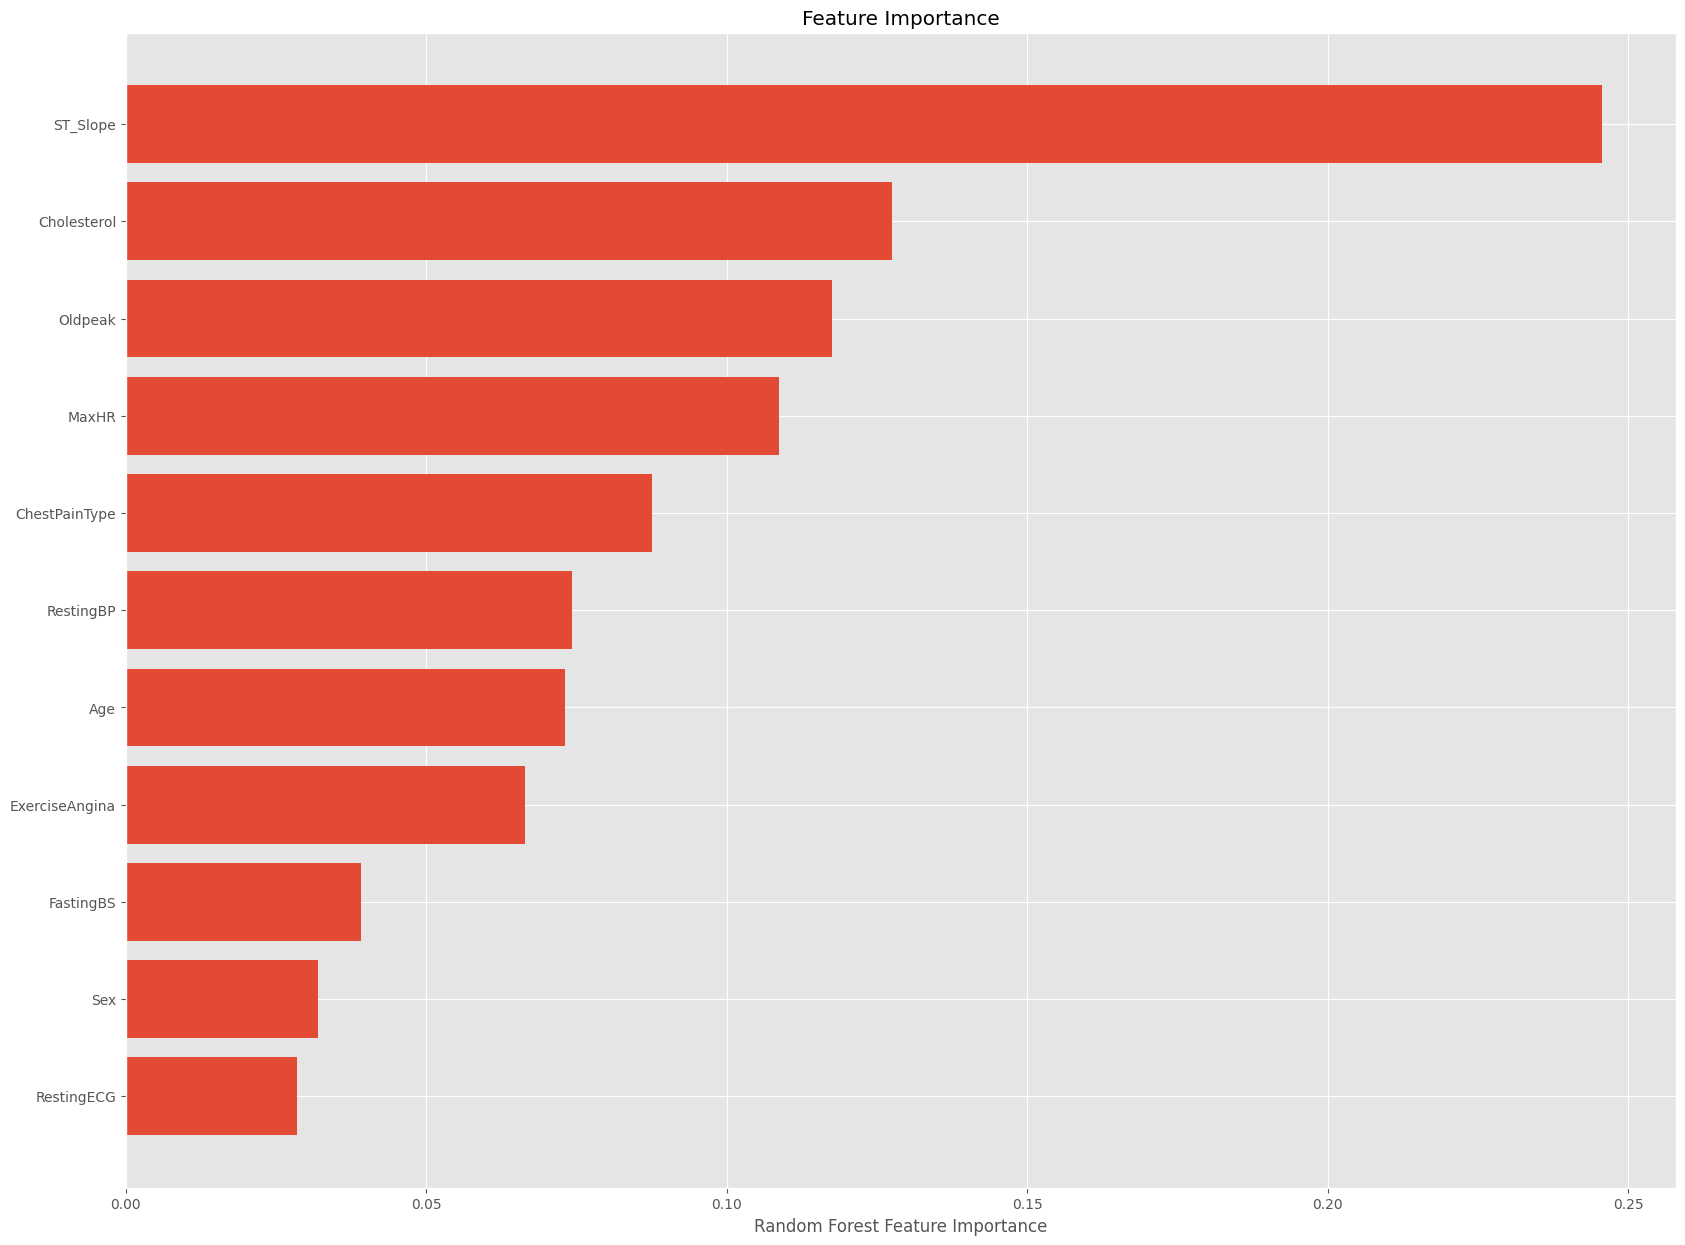

In [97]:
## Выявление наиболее важных признаков

plt.figure(figsize=(20,15))
importance = clf.feature_importances_
idxs = np.argsort(importance)
plt.title("Feature Importance")
plt.barh(range(len(idxs)),importance[idxs],align="center")
plt.yticks(range(len(idxs)),[feature_col_tree[i] for i in idxs])
plt.xlabel("Random Forest Feature Importance")
#plt.tight_layout()
plt.show()

In [109]:
from xgboost import XGBClassifier
acc_mod=recll_sc = []
kf=model_selection.StratifiedKFold(n_splits=5)
for fold , (trn_,val_) in enumerate(kf.split(X=df_tree,y=y)):

    X_train=df_tree.loc[trn_,feature_col_tree]
    y_train=df_tree.loc[trn_,target]

    X_valid=df_tree.loc[val_,feature_col_tree]
    y_valid=df_tree.loc[val_,target]

    clf=XGBClassifier()
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_valid)
    print(clf.predict_proba(X_valid.head(1)))
    #print(X_valid.head(), X_train.shape)
    print(f"The fold is : {fold} : ")
    print(classification_report(y_valid,y_pred))
    acc=roc_auc_score(y_valid,y_pred)
    acc_mod.append(acc)
    print(f"The accuracy for {fold+1} : {acc}")
    recll_sc.append(recall_score(y_valid,y_pred))

dict_res_al.loc["XGBClassifier", ['accuracy','recall']] = [ np.array(acc_mod).mean(),np.array(recll_sc).mean() ]


[[9.9929625e-01 7.0377020e-04]]
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.83      0.93      0.87        82
           1       0.93      0.84      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.89      0.88      0.88       184

The accuracy for 1 : 0.884983261597322
[[9.9978948e-01 2.1055214e-04]]
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.77      0.91      0.84        82
           1       0.92      0.78      0.85       102

    accuracy                           0.84       184
   macro avg       0.85      0.85      0.84       184
weighted avg       0.85      0.84      0.84       184

The accuracy for 2 : 0.8494739359158296
[[9.9982268e-01 1.7731331e-04]]
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.96      0.61      0.75        82
     

In [99]:
"""#визуализация итога работы метода
fig, ax = plt.subplots(figsize=(30, 30))
from xgboost import plot_tree
plot_tree(clf,num_trees=0,rankdir="LR",ax=ax)
plt.show()"""

'#визуализация итога работы метода\nfig, ax = plt.subplots(figsize=(30, 30))\nfrom xgboost import plot_tree\nplot_tree(clf,num_trees=0,rankdir="LR",ax=ax)\nplt.show()'

In [100]:
cb_params = {'iterations': 10000,
             'learning_rate': 0.218904169525507,
             'loss_function': 'MultiClass',
             'eval_metric': 'Accuracy',
             'l2_leaf_reg': 1.6163189485316596,
             'bagging_temperature': 0.14353551008899088,
             'random_strength': 1.29,
             'depth': 10,
             'grow_policy': 'SymmetricTree',
             'leaf_estimation_method': 'Gradient',
             'od_type': 'Iter',
             'early_stopping_rounds': 300,
             'border_count': 254,
             'use_best_model': True,
             'min_data_in_leaf': 150,
             'random_seed': 42}
#протестировав разные гиперпараметры - получили наилучший при стандартном наборе
cb_params = {}

In [101]:
X_valid

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
707,26,1,0,25,124,0,0,35,1,32,1
708,26,1,0,14,64,0,0,34,1,10,1
709,24,1,0,26,70,0,1,94,0,20,2
710,19,1,0,14,133,0,0,44,1,20,1
712,30,1,0,7,92,0,1,82,0,11,2
716,39,1,0,22,95,0,1,5,0,20,1
718,29,1,0,57,147,1,0,50,0,20,1
719,35,1,0,31,112,0,0,73,0,24,1
720,20,1,0,25,132,0,0,92,0,15,1
722,32,0,0,49,116,0,0,83,0,36,1


In [102]:
%%time
splits = 5
skf = model_selection.StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)

X=df_tree.loc[:,feature_col_tree]
y=df_tree.loc[:,target]

oof_preds = np.zeros((X.shape[0],))
preds = np.zeros((X.shape[0],len(np.unique(y))))
model_fi = 0
total_mean_acc = 0
acc_mod = recll_sc = []
for num, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.loc[train_idx], X.loc[valid_idx]
    y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

    model = CatBoostClassifier(**cb_params)
    model.fit(X_train, y_train,
              verbose=False,
              eval_set=(X_valid, y_valid) )

    preds += model.predict_proba(X) / splits

    model_fi += model.feature_importances_ / splits

    oof_preds[valid_idx] = model.predict(X_valid).flatten()

    fold_acc = accuracy_score(y_valid, oof_preds[valid_idx])
    fold_rec = recall_score(y_valid, oof_preds[valid_idx])

    print(f"Fold {num} accuracy: {fold_acc}, recall: {fold_rec}")
    print(classification_report(y_valid,oof_preds[valid_idx]))
    acc=roc_auc_score(y_valid,oof_preds[valid_idx])
    acc_mod.append(acc)
    total_mean_acc += fold_acc / splits
    recll_sc.append(recall_score(y_valid,oof_preds[valid_idx]))

dict_res_al.loc["CatBoostClassifier", ['accuracy','recall']] = [ np.array(acc_mod).mean(),np.array(recll_sc).mean() ]

Fold 0 accuracy: 0.8967391304347826, recall: 0.8921568627450981
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        82
           1       0.92      0.89      0.91       102

    accuracy                           0.90       184
   macro avg       0.89      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

Fold 1 accuracy: 0.8641304347826086, recall: 0.8725490196078431
              precision    recall  f1-score   support

           0       0.84      0.85      0.85        82
           1       0.88      0.87      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Fold 2 accuracy: 0.8532608695652174, recall: 0.9117647058823529
              precision    recall  f1-score   support

           0       0.88      0.78      0.83        82
           1       0.84      0.91      0.87  

In [103]:
dict_res_al

,accuracy,recall
LogisticRegression,0.828790,0.850262
GaussianNB,0.843170,0.843170
SVC(kernel=linear),0.832409,0.832409
SVC(kernel=sigmoid),0.793160,0.793160
SVC(kernel=rbf),0.842030,0.842030
SVC(kernel=poly),0.832258,0.832258
KNeighborsClassifier,0.855244,0.855244
DecisionTreeClassifier,0.729362,0.729362
RandomForestClassifier,0.841901,0.841901
XGBClassifier,0.824876,0.824876


Таким образом самым лучшим алгоритмом получился CatBoost - его и сохраним в отдельный файл для дальнейшего использования

In [104]:
model.save_model(path_in_drive+"/cb_model_pretrained.cbm",
           format="cbm",
           export_parameters=None,
           pool=None)

NameError: name 'print_confusion_matrix' is not defined

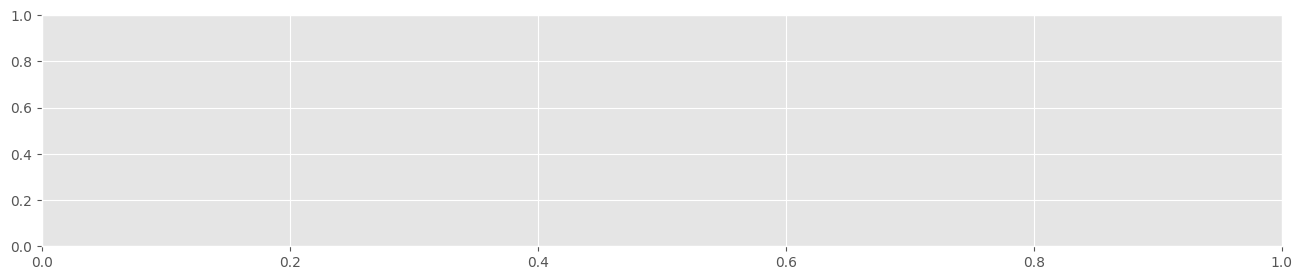

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
    
#for axes, cfs_matrix, label in zip(ax.flatten(), sklearn.metrics.multilabel_confusion_matrix(Z_test, Z_pred_02), labels):
print_confusion_matrix(sklearn.metrics.multilabel_confusion_matrix(y_valid,oof_preds[valid_idx]), axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

#print(sklearn.metrics.classification_report(y_valid,oof_preds[valid_idx], target_names=labels, zero_division=0))

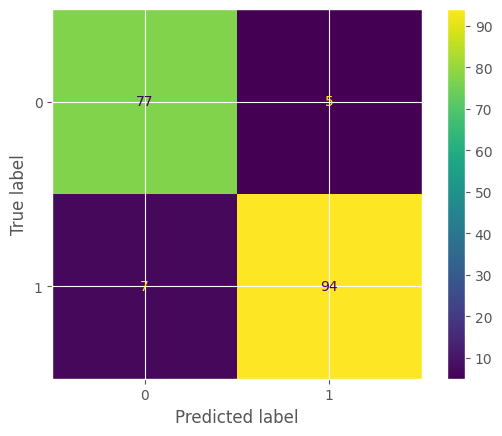

In [117]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
#X, y = make_classification(random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                    random_state=0)
#clf = SVC(random_state=0)
#clf.fit(X_train, y_train)
#random_state=0)
#predictions = clf.predict(X_test)
cm = confusion_matrix(y_valid,model.predict(X_valid), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [116]:
model.predict(X_valid)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0], dtype=int64)

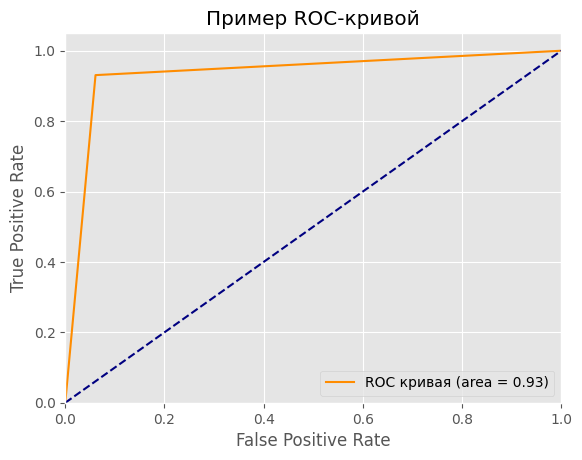

In [120]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
lr_auc = roc_auc_score(y_valid, model.predict(X_valid))
fpr, tpr, treshold = roc_curve(y_valid, model.predict(X_valid))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()